In [1]:
import pickle
from scoring_program.postprocessing import post_process_sql
#from utils.data_io import write_json as write_label
import locale; locale.getpreferredencoding = lambda: "UTF-8" # if necessary

In [2]:
with open('log_probability_test_new.pickle', 'rb') as f:
    data = pickle.load(f)

In [3]:
threshold=425

In [4]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")

In [175]:
reserved=["SELECT", "AS", "IN", "COUNT", "FROM", "WHERE", "AND", "OR", "INSERT", "UPDATE", "DELETE", "CREATE", "DROP", "ALTER", "JOIN", "ON", "GROUP BY", "ORDER BY", "HAVING", "LIMIT", "UNION", "DISTINCT", "INDEX", "TABLE", "VIEW", "TRIGGER", "PRIMARY KEY", "FOREIGN KEY", "NULL", "NOT NULL", "UNIQUE", "CHECK", "DEFAULT", "INDEX", "SEQUENCE", "EXEC", "LIKE", "BETWEEN", "EXISTS", "CASE", "WHEN", "THEN", "ELSE", "END", "CAST", "CHAR", "VARCHAR", "BOOLEAN", "INTEGER", "DATE", "INTERVAL", "TIME", "TIMESTAMP", "YEAR", "MONTH", "DAY", "HOUR", "MINUTE", "SECOND", "ZONE", "CURRENT_DATE", "CURRENT_TIME", "CURRENT_TIMESTAMP", "TRUE", "FALSE"]

def count_words(log):
    total_words = []
    for x in log:
        word = dict(x)['token']
        if word.strip() not in reserved:
            total_words.append(word)

    return len(total_words)

num_distributed = []
for key in data:
    log = data[key][1]
    num = count_words(log)
    num_distributed.append(num)
    #break
print(len(num_distributed))


1167


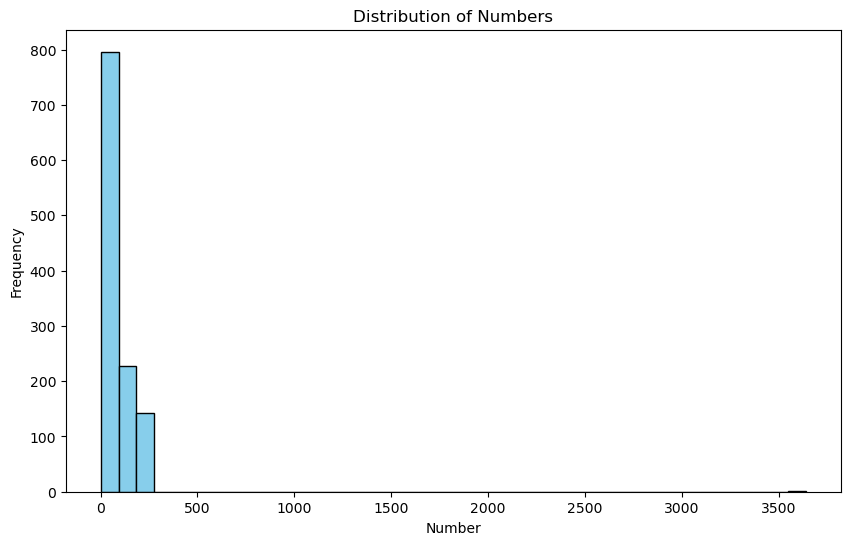

In [176]:


import matplotlib.pyplot as plt

# Provided list of numbers
# Creating the histogram
plt.figure(figsize=(10, 6))
plt.hist(num_distributed, bins=40, color='skyblue', edgecolor='black')
plt.title('Distribution of Numbers')
plt.xlabel('Number')
plt.ylabel('Frequency')

# Show plot
plt.show()

In [177]:
def calculate_log_bottom_k(log, k):
    #하위 k개의 token에 대한 logprob에 대한평균
    total_logprob = []
    for x in log:
        word = dict(x)['token']
        if word.strip() not in reserved:
            total_logprob.append(dict(x)['logprob'])

    total_logprob.sort()
    if(len(total_logprob) > k):
        total_logprob = total_logprob[:k]
    
    return sum(total_logprob) / len(total_logprob)

In [178]:
k=10
log_index={}
log_value=[]
for key in data:
    log = data[key][1]
    avg_log = calculate_log_bottom_k(log, k)
    #avg_log = calculate_log_bottom_k_entity(log, k)
    #print(avg_log)
    log_index[key]=avg_log
    log_value.append(avg_log)

In [179]:
log_index

{'282f008dd8dfb8f4a1dd6999': -1.4695559464999997e-05,
 '47fd000ef0b1033a8aabfac8': -3.4417257799999997e-07,
 '7f07c59357750ac2b84e5221': -3.6044574226000004e-05,
 'c83990de3e5d2d218c83528a': -0.06358593546893501,
 'f430a02bd152c617a86cd2c3': -9.826787363000001e-06,
 '34e18d3b9b2f055f37a2d04d': -0.22795034626599997,
 'dfc058cc8e8d30a29c0177b9': -5.195092688699999e-05,
 '4b10d0fec2f23acab915e3f3': -3.42654568e-07,
 '647bc08d18cac6dbda791c42': 0.0,
 '20c3ddd36c65c44890c3f3e5': -8.716301259999999e-07,
 '5436413908d5e902536630e8': -5.088478498e-06,
 '4ea7d91dc5b0b0f4da0cb1c6': -8.01551358e-07,
 '4f489c24ce6a5dfb8485d4f0': -0.5913645033333333,
 '2675abf72b38410bb4eda4ad': -0.019480144217600005,
 '3fc7c5e0ee947f0f155f81ae': -1.8024889300000002e-07,
 '647fbc4c18dc9b7300f25187': -2.6224059479999996e-06,
 '289be48fc696c588e5a69f9c': -3.8737459e-07,
 '3aa4a932c5d33d1b18e92ccc': -0.046955346856065006,
 '9e26fb10ef1cbf36ec4e516b': -0.31152467298076403,
 'eeca589fced0d6ee197e6a2b': -0.132825081836,


In [180]:
log_value.sort()

In [181]:
log_value[threshold]

-1.740855783e-05

In [182]:
len(log_value)

1167

In [183]:
answer={}
for key in data:
    if log_index[key] <= log_value[threshold]:
        answer[key]='null'
    else:
        answer[key]=post_process_sql(data[key][0])

In [184]:
answer

{'282f008dd8dfb8f4a1dd6999': "SELECT microbiologyevents.org_name FROM microbiologyevents WHERE microbiologyevents.hadm_id IN ( SELECT admissions.hadm_id FROM admissions WHERE admissions.subject_id = 10027602 AND admissions.dischtime IS NOT NULL ORDER BY admissions.admittime ASC LIMIT 1 ) AND microbiologyevents.spec_type_desc = 'urine' AND microbiologyevents.org_name IS NOT NULL ORDER BY microbiologyevents.charttime DESC LIMIT 1",
 '47fd000ef0b1033a8aabfac8': "SELECT T1.drug FROM ( SELECT prescriptions.drug, DENSE_RANK() OVER ( ORDER BY COUNT(*) DESC ) AS C1 FROM prescriptions WHERE strftime('%Y',prescriptions.starttime) >= '2100' GROUP BY prescriptions.drug ) AS T1 WHERE T1.C1 <= 5",
 '7f07c59357750ac2b84e5221': 'null',
 'c83990de3e5d2d218c83528a': 'null',
 'f430a02bd152c617a86cd2c3': "SELECT SUM(cost.cost) FROM cost WHERE cost.hadm_id IN ( SELECT admissions.hadm_id FROM admissions WHERE admissions.subject_id = 10038933 ) AND strftime('%Y',cost.chargetime) = '2100'",
 '34e18d3b9b2f055f

In [185]:
null=0
nonnull=0
for key in answer:
    if answer[key]=="null":
        null +=1
    else:
        nonnull +=1
print(null, nonnull)

421 746


In [186]:
import json
with open(f"log_prob_{threshold}_bottom_{k}.json", "w") as json_file:
    json.dump(answer, json_file)